In [1]:
import re
import unicodedata
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from env import user, password, host

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare

### 1. Spam Data

#### a. Load the spam data set.

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    '''
    This function cleans up text data.
    '''
    
    #lemmatize
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    #normalize
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
#look at how many messages are spam vs ham
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']

labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
#breaking up data into 3 separate pieces

#words that appear in legitimate text messages
ham_words = clean(' '.join(df[df.label == 'ham'].text))

#words that appear in spam text messages
spam_words = clean(' '.join(df[df.label == 'spam'].text))

#all of the words
all_words = clean(' '.join(df.text))

In [6]:
ham_words[:5]

['go', 'jurong', 'point', 'crazy', 'available']

In [7]:
spam_words[:5]

['free', 'entry', 'wkly', 'comp', 'win']

In [8]:
all_words[:15]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore']

In [9]:
#w/ list of words, we can transform it into a pandas Series,
#which can show how often each of the words occurs
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [10]:
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

In [11]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [12]:
all_freq.head()

call    600
im      462
get     397
ur      384
go      304
dtype: int64

In [13]:
#combine these 3 together to get one resulting df
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail(20)

,all,ham,spam
yunny,2,2,0
yuo,4,4,0
yuou,1,1,0
yup,43,43,0
yupz,1,1,0
ywhere,1,1,0
z,1,1,0
zac,1,1,0
zahers,1,1,0
zealand,1,1,0


In [14]:
#What are the most frequently occuring words?
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [15]:
#Are there any words that uniquely identify a spam or ham message?
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
didnt,79,79,0
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0


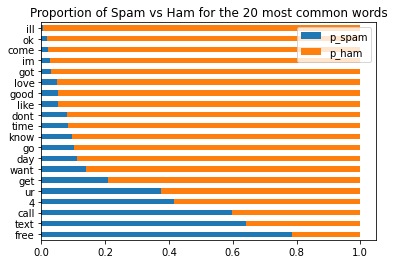

In [16]:
#visualize percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.show()

In [17]:
#get ratio
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


#### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

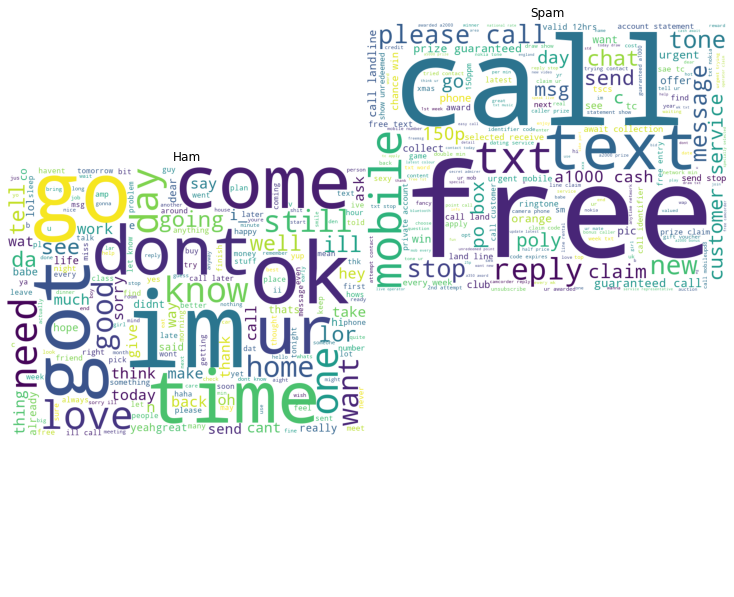

In [18]:
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(ham_cloud)
axs[1].imshow(spam_cloud)

axs[0].set_title('Ham')
axs[1].set_title('Spam')

for ax in axs: ax.axis('off')    


#### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [19]:
#spam bigrams
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

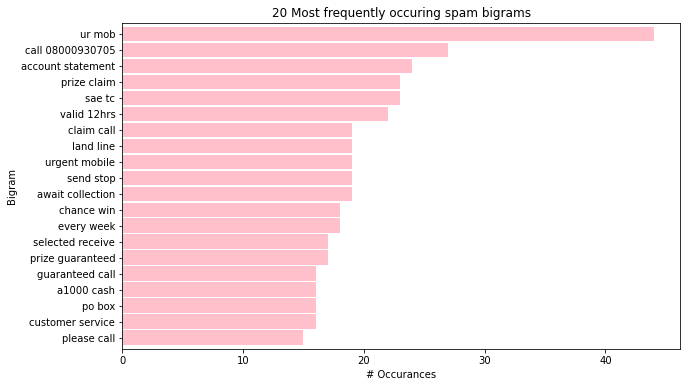

In [20]:
top_20_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [21]:
#ham bigrams
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

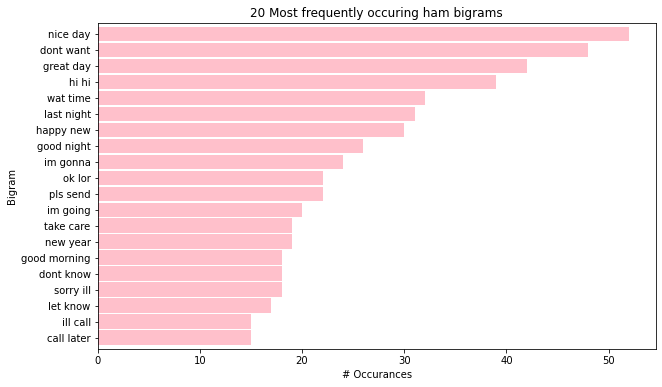

In [22]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

#### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [27]:
#spam trigrams
top_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))


top_spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(reply, call, 08000930705)             14
(land, line, claim)                    14
(private, 2003, account)               13
(2003, account, statement)             13
(camcorder, reply, call)               12
(show, 800, unredeemed)                12
(guaranteed, a1000, cash)              12
(urgent, trying, contact)              11
(anytime, network, min)                11
(please, call, customer)               11
(every, week, txt)                     11
(tone, 4, ur)                          11
(bonus, caller, prize)                 11
(a2000, bonus, caller)                 10
(cash, await, collection)              10
(speak, live, operator)                10
(customer, service, representative)    10
(txt, music, 87066)                     9
dtype: int64

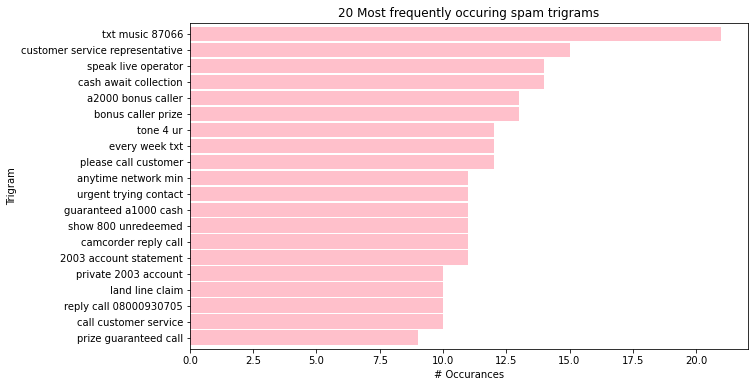

In [36]:
top_spam_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

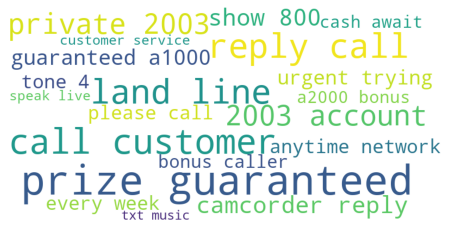

In [33]:
#use top spam trigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [28]:
#ham trigrams
top_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_ham_trigrams

(ill, call, later)            42
(sorry, ill, call)            38
(happy, new, year)            19
(pls, send, message)          13
(cant, pick, phone)           12
(phone, right, pls)           12
(pick, phone, right)          12
(right, pls, send)            12
(hi, hi, hi)                  11
(x, x, x)                      8
(good, morning, dear)          7
(call, later, meeting)         6
(convey, birthday, wish)       6
(pls, convey, birthday)        6
(kiss, across, sea)            6
(set, callertune, caller)      5
(press, 9, copy)               5
(forgot, n, kid)               5
(sed, sexy, mood)              5
(goodmorning, today, late)     5
dtype: int64

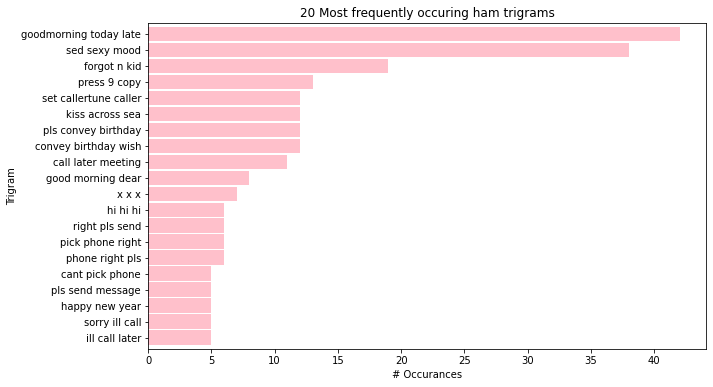

In [37]:
top_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

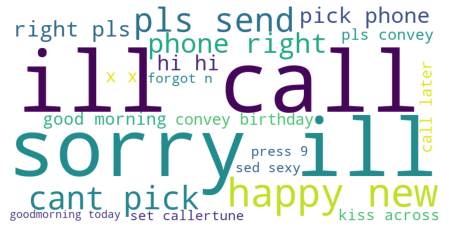

In [32]:
#use top ham trigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.